<a href="https://colab.research.google.com/github/RashiMakharia/Bioinformatics-Pipeline/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython matplotlib numpy requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 85.9 MB/s eta 0:00:00



🔹 Fetching nucleotide record for NM_000321...
Description: Homo sapiens RB transcriptional corepressor 1 (RB1), transcript variant 1, mRNA
Sequence length: 4768 bp
Total features: 67

✅ CDS extracted: 2787 bp
Translated protein length: 928 amino acids

🔹 Fetching PDB sequence for 1NQL...
Selected PDB chain: 1NQL_1|Chain (length 624 aa)

🔹 Performing protein alignment...
Alignment Score: -108.50

--- Alignment Preview ---
MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVRLEFEETEEPDFTALCQKLKIPDHVRERAWLTWEKV-SSVDGVLGG----YIQKKKELWGICIFIAAVDLDEMSF...
----------------------------------------------LEEKKVCQGTSNKLTQLGTFEDH-----FLSLQRMFNNCEVVLGNLEITYVQRNYDL---------------SF...


🔹 Displaying GC content plot...


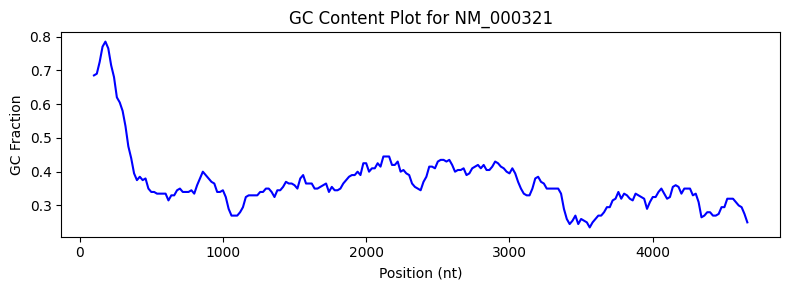


🔹 Displaying Hydrophobicity plot...


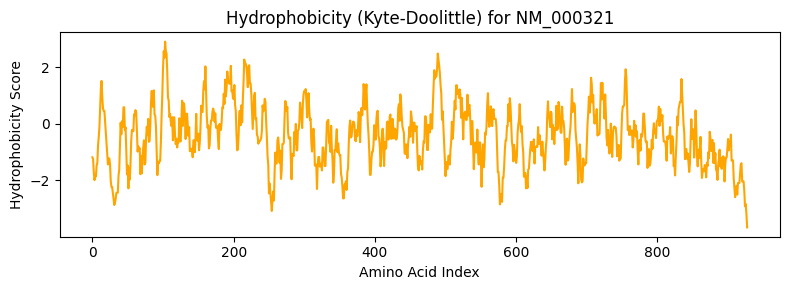


✅ Pipeline finished — all results displayed successfully.



In [11]:
"""
Biopython Pipeline (Display-Only Version)
For:
 - Nucleotide accession: NM_000321
 - PDB ID: 1NQL

Performs:
 - Sequence fetching from NCBI and RCSB
 - Parsing GenBank features
 - CDS extraction and translation
 - Protein alignment
 - GC content and hydrophobicity visualization
 - Displays all outputs (no files saved)
"""

import io
from typing import List, Optional, Dict, Tuple
from dataclasses import dataclass

from Bio import Entrez, SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB import PDBList, PDBParser, PPBuilder
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
import numpy as np
import requests

# ---------------- CONFIG ----------------
Entrez.email = "rashimakharia21@gmail.com"

# ---------------- DATA CLASS ----------------
@dataclass
class FetchResult:
    record: SeqRecord
    source: str

# ---------------- FETCH SEQUENCES ----------------
def fetch_refseq_genbank(accession: str) -> FetchResult:
    with Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text") as handle:
        rec = SeqIO.read(handle, "genbank")
    return FetchResult(record=rec, source="genbank")

def fetch_pdb_fasta(pdb_id: str) -> List[SeqRecord]:
    url = f"https://www.rcsb.org/fasta/entry/{pdb_id}"
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    fasta_text = r.text
    return list(SeqIO.parse(io.StringIO(fasta_text), "fasta"))

# ---------------- FEATURE & TRANSLATION ----------------
def get_cds_sequence_from_record(rec: SeqRecord) -> Optional[Seq]:
    for f in rec.features:
        if f.type == "CDS":
            try:
                return f.extract(rec.seq)
            except Exception:
                continue
    return None

def translate_seq(dna_seq: Seq, table: int = 1, to_stop: bool = True) -> Seq:
    return dna_seq.translate(table=table, to_stop=to_stop)

# ---------------- ALIGNMENT ----------------
def align_proteins(prot_a: Seq, prot_b: Seq):
    try:
        matrix = substitution_matrices.load("BLOSUM62")
        alns = pairwise2.align.globalds(str(prot_a), str(prot_b), matrix, -10, -0.5)
    except Exception:
        alns = pairwise2.align.globalms(str(prot_a), str(prot_b), 2, -1, -10, -0.5)
    if not alns:
        return None
    return alns[0]

# ---------------- VISUALIZATION HELPERS ----------------
KD_MAP = {
    'I':4.5,'V':4.2,'L':3.8,'F':2.8,'C':2.5,'M':1.9,'A':1.8,'G':-0.4,
    'T':-0.7,'S':-0.8,'W':-0.9,'Y':-1.3,'P':-1.6,'H':-3.2,'E':-3.5,
    'Q':-3.5,'D':-3.5,'N':-3.5,'K':-3.9,'R':-4.5
}

def sliding_gc_content(seq: Seq, window: int = 200, step: int = 20):
    s = str(seq).upper()
    pos, vals = [], []
    for i in range(0, max(1, len(s)-window+1), step):
        win = s[i:i+window]
        gc = (win.count("G")+win.count("C")) / max(1, len(win))
        pos.append(i + window//2)
        vals.append(gc)
    return pos, vals

def sliding_hydrophobicity(prot: Seq, window: int = 9):
    s = str(prot)
    pos, vals = [], []
    half = window//2
    for i in range(len(s)):
        win = s[max(0,i-half):min(len(s),i+half+1)]
        score = np.mean([KD_MAP.get(aa,0) for aa in win])
        pos.append(i)
        vals.append(score)
    return pos, vals

# ---------------- MAIN PIPELINE ----------------
def pipeline(nuc_accession: str, pdb_id: str):
    print(f"\n🔹 Fetching nucleotide record for {nuc_accession}...")
    nuc_fetch = fetch_refseq_genbank(nuc_accession)
    nuc_rec = nuc_fetch.record
    print(f"Description: {nuc_rec.description}")
    print(f"Sequence length: {len(nuc_rec.seq)} bp")
    print(f"Total features: {len(nuc_rec.features)}")

    cds_seq = get_cds_sequence_from_record(nuc_rec)
    if cds_seq:
        print(f"\n✅ CDS extracted: {len(cds_seq)} bp")
    else:
        print("⚠️ No CDS found — using full sequence.")
        cds_seq = nuc_rec.seq

    prot_seq = translate_seq(cds_seq)
    print(f"Translated protein length: {len(prot_seq)} amino acids")

    print(f"\n🔹 Fetching PDB sequence for {pdb_id}...")
    pdb_records = fetch_pdb_fasta(pdb_id)
    if not pdb_records:
        print("⚠️ No PDB FASTA found.")
        return
    pdb_target = max(pdb_records, key=lambda r: len(r.seq))
    print(f"Selected PDB chain: {pdb_target.id} (length {len(pdb_target.seq)} aa)")

    print("\n🔹 Performing protein alignment...")
    aln = align_proteins(prot_seq, pdb_target.seq)
    if aln:
        a1, a2, score, start, end = aln
        print(f"Alignment Score: {score:.2f}")
        print("\n--- Alignment Preview ---")
        print(a1[:120] + "...")
        print(a2[:120] + "...\n")
    else:
        print("⚠️ Alignment failed.")

    # ---------------- VISUALIZATIONS ----------------
    print("\n🔹 Displaying GC content plot...")
    pos, gc_vals = sliding_gc_content(nuc_rec.seq)
    plt.figure(figsize=(8,3))
    plt.plot(pos, gc_vals, color='blue')
    plt.title(f"GC Content Plot for {nuc_accession}")
    plt.xlabel("Position (nt)")
    plt.ylabel("GC Fraction")
    plt.tight_layout()
    plt.show()

    print("\n🔹 Displaying Hydrophobicity plot...")
    pos, hyd_vals = sliding_hydrophobicity(prot_seq)
    plt.figure(figsize=(8,3))
    plt.plot(pos, hyd_vals, color='orange')
    plt.title(f"Hydrophobicity (Kyte-Doolittle) for {nuc_accession}")
    plt.xlabel("Amino Acid Index")
    plt.ylabel("Hydrophobicity Score")
    plt.tight_layout()
    plt.show()

    print("\n✅ Pipeline finished — all results displayed successfully.\n")

# ---------------- RUN ----------------
if __name__ == "__main__":
    pipeline("NM_000321", "1NQL")
